06 XGBoost(eXtra Gradient Boost)
(1) XGBoost 개요
분류와 회귀 있어 일반적으로 다른 머신러닝보다 뛰어난 예측 성능
GBM에 기반하고 있지만 병렬 수행 및 다양한 기능으로 GBM에 비해 빠른 수행 성능 보장 (랜덤포레스트보다 빠르지는 않음)
과적합 규제 (regularization) : 표준 GBM과 달리 자체에 과적합 규제 기능으로 좀더 강한 내구성을 가질 수 있음
Tree pruning으로 더이상 긍정 이득이 없는 분할을 가지치기해서 분할수를 줄이는 추가적인 장점을 가지고 있음
반복 수행 시마다 내부적으로 학습 데이터 세트와 평가 데이터 세트에 대한 교차검증을 수행해 최적화된 반복 수행 횟수를 가질 수 있음
지정된 반복 횟수가 아니라 교차 검증을 통해 평가 데이터 세트의 평가 값이 최적화되면 반복을 중간에 멈출 수 있는 조기 중단 기능이 있음
결손값을 자체 처리할 수 있는 기능을 가지고 있음
xgboost 패키지 내에는 XGBoost 전용의 파이썬 패키지와 사이킷런과 호환되는 래퍼용(Wrapper class) XGBoost가 함께 존재
래퍼 클래스인 XGBClassifier와 XGBRegressor를 이용하면 fit()과 predict()같은 표준 사이킷런 개발 프로세스 및 다양한 유틸리티 활용 가능
1) 파이썬 래퍼 XGBoost 모듈 : 초기 독자적인 XGBoost 프레임워크 기반의 XGBoost. 고유의 API와 하이퍼파라미터 이용
2) 사이킷런 래퍼 XGBoost 모듈 : 사이킷런과 연동 가능


(2) 파이썬 래퍼 XGBoost 하이퍼 파라미터

부스터 파라미터 : 트리 최적화, 부스팅, reguliarization 등과 관련 파라미터
eta : GBM의 학습률과 같은 파라미터
num_boost_rounds : GBM의 n_estimators와 같은 파라미터
min_child_weight : 트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요한 데이터들의 weight 총합
gamma : 트리의 리프 노드를 추가적으로 나눌지를 결정할 최소 손실 감소 값
max_depth : 트리 기반 알고리즘의 max_depth와 같음
sub_sample : GBM의 sub_sample과 동일 > 데이터를 샘플링하는 비율을 지정
colsample_type : 트리 생성에 필요한 피처를 임의로 샘플링하는데 사용
lambda : L2 Regulairization 적용 값
alpha : L1 Regularizaion 적용 값, 값이 클수록 과적합 감소
scale_pos_weight : 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터
학습 태스크 파라미터 : 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터
objective : 최솟값을 가져야 할 손실함수를 정의
binary:logistic : 이진 분류
multi:softmax : 다중 분류일때 적용
multi:softprob : 개별 레이블 클래스의 해당되는 예측 확률을 반환
eval_metric : 검증에 사용되는 함수를 정의
rmse, mae, logloss, error, merror, mlogloss, auc
과적합 문제가 심각하다면
eta 값 낮추고, num_round 높이기
max_depth 값 낮추기
min_child_weight 값 높이기
gamma 값 높이기

In [5]:
# XGBoost 버전확인
import xgboost
print(xgboost.__version__)

1.5.2


In [6]:
import xgboost as xgb
from xgboost import plot_importance # 피처 중요도 시각화 모듈
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df=pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [7]:
# 레이블값 분포 확인
print(dataset.target_names)
print(cancer_df['target'].value_counts())
# 1값이 양성, 0값이 악성

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [8]:
#데이터 세트 분할
X_train,X_test,y_train,y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [9]:
dtrain=xgb.DMatrix(data=X_train, label=y_train)
dtest=xgb.DMatrix(data=X_test,label=y_test)

In [10]:
params={'max_depth':3,
        'eta':0.1,
        'objective':'binary:logistic',
        'eval_metric':'logloss',
        'early_stoppings':100}
num_rounds=400

파이썬 래퍼 XGBoost는 하이퍼 파라미터를 xgboost 모듈의 train()함수에 파라미터로 전달
조기중단은 train함수에 early_stopping_rounds 파라미터를 입력하여 설정함
eval_set : 성능 평가를 수행할 평가용 데이터 세트를 설정
eval_metirc : 평가 세트에 적용할 성능 평가 방법. 분류일 경우 주로 error, logloss를 사용
eval 파라미터의 학습 데이터 세트와 eval 데이터 세트를 명기해주면 평가르 eval 데이터 세트에 수행하면서 조기 중단 적용 가능

In [11]:
#train 데이터 세트는 'train', evalution(test) 데이터 세트는 'eval로 명기
wlist=[(dtrain,'train'),(dtest,'eval')]
#하이퍼 파라미터와 early stopping 파라미터를 train()함수의 파라미터로 전달
xgb_model=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_rounds, early_stopping_rounds=100,evals=wlist)

[18:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stoppings" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train

In [12]:
pred_probs=xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


get_clf_eval() 함수를 적용해 XGBoost 모델의 예측 성능을 평가

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion=confusion_matrix(y_test,pred)
  accuracy=accuracy_score(y_test,pred)
  precision=precision_score(y_test,pred)
  recall=recall_score(y_test,pred)
  f1=f1_score(y_test,pred)

  #ROC_AUC 추가
  roc_auc=roc_auc_score(y_test,pred_proba)
  print('오차 행렬')
  print(confusion)
  #ROC-AUC print 추가
  print('정확도:{0:.4f},정밀도:{1:.4f},재현율:{2:.4f},F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

In [14]:
get_clf_eval(y_test,preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도:0.9737,정밀도:0.9744,재현율:0.9870,F1:0.9806, AUC:0.9951


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

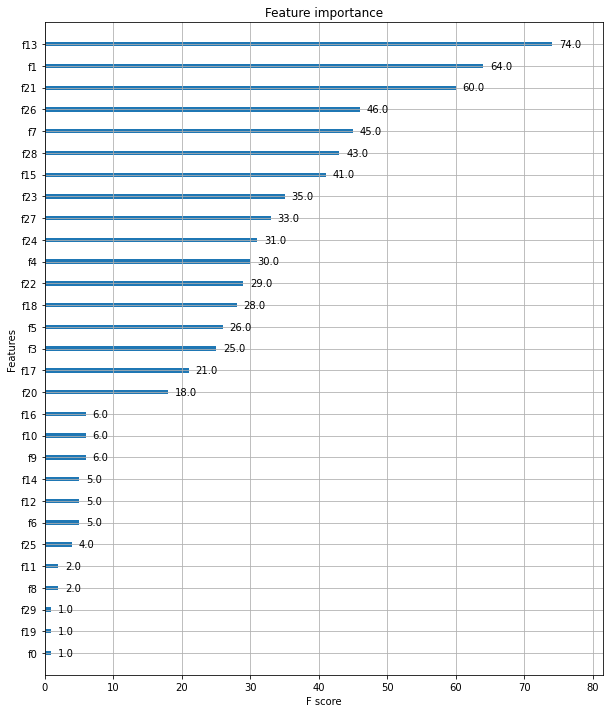

In [15]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)

3) 사이킷런 래퍼 XGBoost의 개요 및 적용

XGBoost개발 그룹은 사이킷런의 프레임워크와 연동하기 위해 사이킷런 전용의 XGBoost 래퍼 클래스를 개발함
사이킷런의 기본 Estimator를 그대로 상속해 만들었기 때무에 다른 Estimator와 동일하게 fit(), predict()만으로 학습과 예측 가능
사이킷런의 다른 유틸리티 그대로 사용 가능 > 기존의 다른 머신러닝 알고리즘으로 만들어둔 프로그램이 있더라도 알고리즘 클래스만 XGboost 래퍼 클래스로 바꾸면 기존 프로그램 그대로 사용 가능
XGBClassifier, XGBRegressor
하이퍼 파라미터 변경( 파이썬 래퍼 XGBoost -> 사이킷런 래퍼 XGBoost)
eta -> learning_rate
sub_sample -> subsample
lambda -> reg_lambda
alpha -> reg_alpha
xgboost의 n_estimators와 num_boost_round는 같은 파라미터
사이킷런 래퍼 XGBoost는 n_estimator를 사용, 파이썬 래퍼 XGBoost는 num_boost_round 사용 (둘 다 입력될 시)
위스콘신 유방암 데이터를 XGBClassifier를 이용하여 예측

In [16]:
#사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds=xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[18:23:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [17]:
get_clf_eval(y_test,w_preds,w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도:0.9737,정밀도:0.9744,재현율:0.9870,F1:0.9806, AUC:0.9951


In [18]:
#데이터 세트의 크기가 작아 테스트 데이터를 평가용으로 사용했음
from xgboost import XGBClassifier
xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1,max_depth=3)
evals=[(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss',
                eval_set=evals, verbose=True)
ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [19]:
get_clf_eval(y_test, ws100_preds,ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도:0.9649,정밀도:0.9620,재현율:0.9870,F1:0.9744, AUC:0.9954


In [20]:
#early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)

ws10_preds=xgb_wrapper.predict(X_test)
ws10_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test,ws10_preds,ws10_pred_proba)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

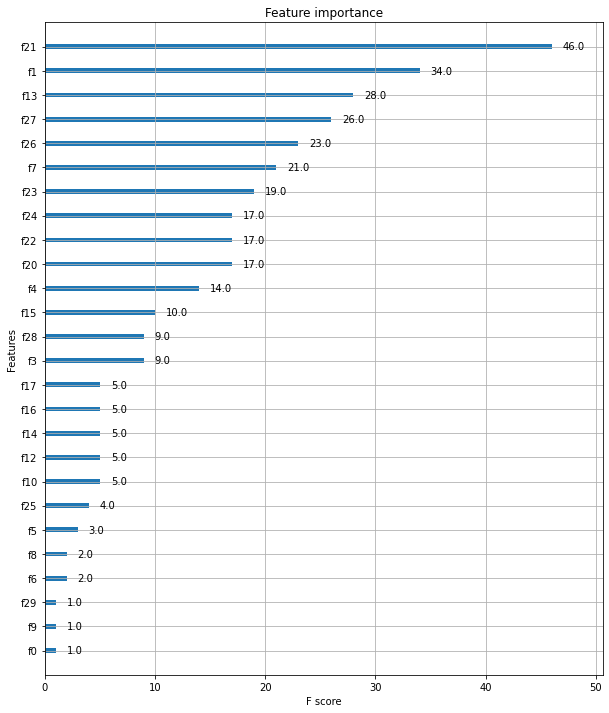

In [21]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
#사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper,ax=ax)

7. LightGBM
XGBoost에서 GridSearchCV로 하이퍼 파라미터 튜닝을 수행하다보면 수행시간이 너무 오래 걸려서 많은 파라미터를 튜닝하기에 어려움이 있음
LightGBM은 XGBoost보다 시간이 훨씬 적게 걸리고 메모리 사용량도 적음
예측 성능은 XGBoost와 비슷
LightGBM은 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉬움(10000건 이하의 데이터 세트 정도)
리프중심 트리 분학 방식
기존의 대부분 트리 기반 알고리즘은 균형 트리 분할 방식 사용 > 최대한 균형잡힌 트리를 유지하면서 분할함
트리의 균형을 맞추지 않고 최대 손실 값을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성됨
패키지명 : lightgbm
사이킷런 래퍼 LightGBM 클래스 : LGBMClassifier, LGBMRegressor

- LightGBM 적용 - 위스콘신 유방암 예측

In [22]:
#LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()
ftr=dataset.data
target=dataset.target

#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터로 추출
X_train,X_test,y_train,y_test=train_test_split(ftr,target, test_size=0.2,random_state=156)

#앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper=LGBMClassifier(n_estimators=400)

#LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals=[(X_test,y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
preds=lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

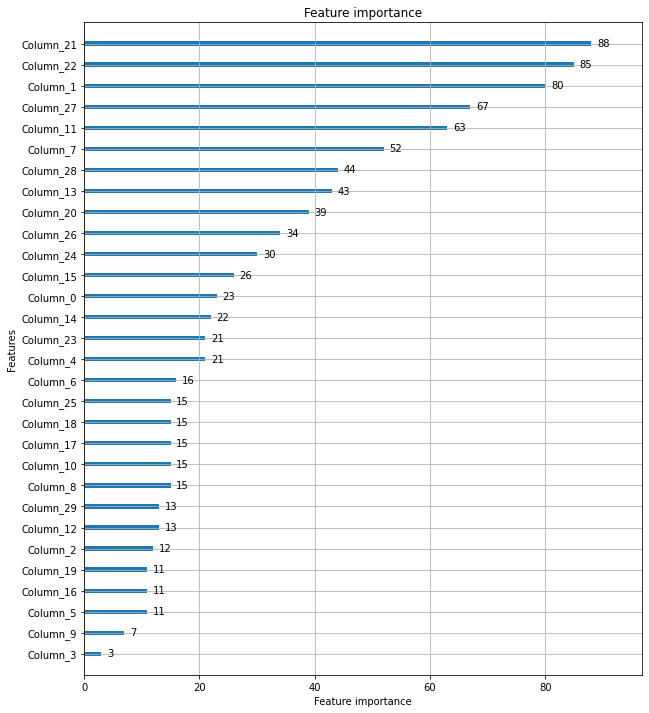

In [23]:
#plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)

10.스태킹 앙상블

In [24]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data=load_breast_cancer()

X_data=cancer_data.data
y_label=cancer_data.target

X_train,X_test,y_train,y_test=train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [25]:
#개별 ML모델 생성
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final=LogisticRegression(C=10)

#개별 모델들을 학습
knn_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
dt_clf.fit(X_train,y_train)
ada_clf.fit(X_train,y_train)

#학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)


print('KNN 정확도:{0:.4f}'.format(accuracy_score(y_test,knn_pred)))
print('랜덤포레스트 정확도:{0:.4f}'.format(accuracy_score(y_test,rf_pred)))
print('결정 트리 정확도:{0:.4f}'.format(accuracy_score(y_test,dt_pred)))
print('에이다부스트 정확도:{0:.4f}'.format(accuracy_score(y_test,ada_pred)))

KNN 정확도:0.9211
랜덤포레스트 정확도:0.9649
결정 트리 정확도:0.9123
에이다부스트 정확도:0.9561


In [26]:
pred=np.array([knn_pred,rf_pred,dt_pred,ada_pred])
print(pred.shape)

#transpose를 이용해 행과 열의 위치 교환, 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred=np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [27]:
lr_final.fit(pred,y_test)
final=lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도 : {0:.4f}'.format(accuracy_score(y_test,final)))

최종 메타 모델의 예측 정확도 : 0.9737


In [29]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n,y_train_n,X_test_n,n_folds):
  kf=KFold(n_splits=n_folds,shuffle=True, random_state=0)
  train_fold_pred=np.zeros((X_train_n.shape[0],1))
  test_pred=np.zeros((X_test_n.shape[0],n_folds))
  print(model.__class__.__name__,'model 시작')

  for folder_counter,(train_index,valid_index) in enumerate(kf.split(X_train_n)):
    print('\t 폴드 세트 : ',folder_counter,'시작')
    X_tr=X_train_n[train_index]
    y_tr=y_train_n[train_index]
    X_te=X_train_n[valid_index]

    model.fit(X_tr,y_tr)
    train_fold_pred[valid_index,:]=model.predict(X_te).reshape(-1,1)
    test_pred[:,folder_counter]=model.predict(X_test_n)

  test_pred_mean=np.mean(test_pred,axis=1).reshape(-1,1)

  return train_fold_pred,test_pred_mean